In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import os
import copy

from tqdm import tqdm

from PIL import Image
Image.MAX_IMAGE_PIXELS = 120000000

In [2]:
# Load the data using ImageFolder
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = torchvision.datasets.ImageFolder(root='./images', transform=data_transform)

In [3]:
# Split the data into training, validation and testing sets
train_size = int(0.5 * len(image_dataset))
val_size = int(0.25 * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(image_dataset, [train_size, val_size, test_size])

In [17]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, num_workers=6)


In [4]:
# Create data loaders for the training and validation sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=6)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=True, num_workers=6)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=6)

# Set up dict for dataloaders
dataloaders = {'train': train_loader,
               'val': val_loader,
               'test': test_loader}

In [5]:
# Store size of training and validation sets
dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}

print(dataset_sizes)

# Get class names associated with labels
class_names = image_dataset.classes
print(class_names)

{'train': 21542, 'val': 10771, 'test': 10771}
['neutral', 'nsfw']


In [6]:
# Load the ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze the model parameters
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully-connected layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

In [7]:
device =  "cpu"
if torch.cuda.is_available():
    device = "cuda"
    
# Move the model to the GPU
device = torch.device(device)
model = model.to(device)

In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Learning rate scheduler - decay LR by a factor of 0.1 every 7 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Keep track of the best model's performance on the validation set
best_acc = 0.0
best_model_wts = model.state_dict()

In [9]:
def train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=25):
    model = model.to(device) # Send model to GPU if available
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            batch_count = 0

            # Get the input images and labels, and send to GPU if available
            for inputs, labels in dataloaders[phase]:
                
                if batch_count % 10 == 0 and phase == 'train':
                    print('Batch {}/{}'.format(batch_count, len(dataloaders[phase])))
                    
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the weight gradients
                optimizer.zero_grad()

                # Forward pass to get outputs and calculate loss
                # Track gradient only for training data
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backpropagation to get the gradients with respect to each weight
                    # Only if in train
                    if phase == 'train':
                        loss.backward()
                        # Update the weights
                        optimizer.step()

                # Convert loss into a scalar and add it to running_loss
                running_loss += loss.item() * inputs.size(0)
                # Track number of correct predictions
                running_corrects += torch.sum(preds == labels.data)
                
                batch_count += 1

            # Step along learning rate scheduler when in train
            if phase == 'train':
                scheduler.step()

            # Calculate and display average loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # If model performs better on val set, save weights as the best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:3f}'.format(best_acc))

    # Load the weights from best model
    model.load_state_dict(best_model_wts)

    return model

In [11]:
#Train the model
model = train_model(model, criterion, optimizer, dataloaders, scheduler, device, num_epochs=5)

Epoch 0/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.5007 Acc: 0.7852
val Loss: 0.3497 Acc: 0.8476

Epoch 1/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.3156 Acc: 0.8726
val Loss: 0.2800 Acc: 0.8942

Epoch 2/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2727 Acc: 0.8957
val Loss: 0.2596 Acc: 0.9044

Epoch 3/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2576 Acc: 0.9024
val Loss: 0.2465 Acc: 0.9066

Epoch 4/4
----------
Batch 0/43
Batch 10/43
Batch 20/43
Batch 30/43
Batch 40/43
train Loss: 0.2494 Acc: 0.9060
val Loss: 0.2384 Acc: 0.9095

Training complete in 29m 24s
Best val Acc: 0.909479


In [12]:
torch.save(model, './model/best_model.pt')

In [14]:
trained_model = torch.load('./model/best_model.pt')
trained_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

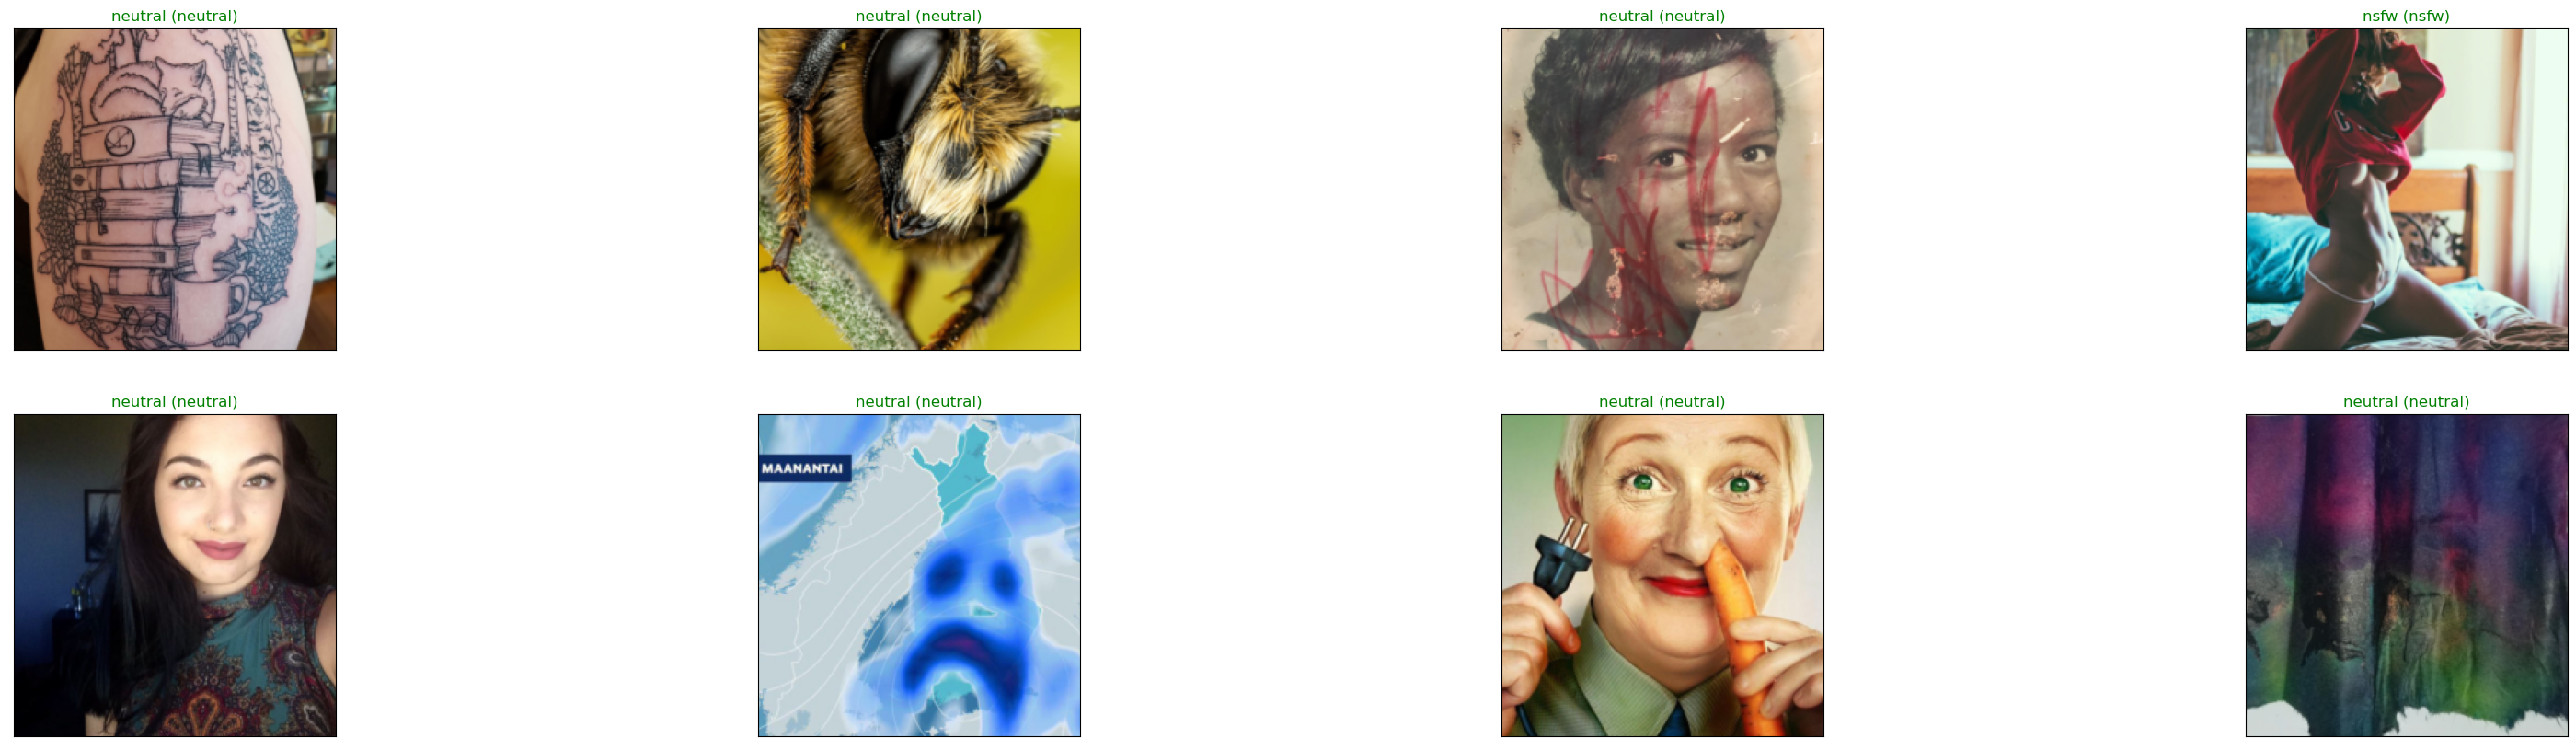

In [25]:
# Display a batch of predictions
def visualize_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = next(iter(dataloader))
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        _,preds = torch.max(model(images), 1)
        preds = np.squeeze(preds.cpu().numpy())
        images = images.cpu().numpy()

    # Plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(40, 10))
    for idx in np.arange(len(preds)):
        ax = fig.add_subplot(2, len(preds)//2, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        ax.imshow(image)
        ax.set_title("{} ({})".format(class_names[preds[idx]], class_names[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx] else "red"))
    return

visualize_results(trained_model, test_loader, device)